In [56]:
%pip install imbalanced-learn

StatementMeta(pocsparkpool, 37, 40, Finished, Available, Finished)


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

StatementMeta(pocsparkpool, 37, 42, Finished, Available, Finished)

In [58]:
def load_and_preprocess(csv_path, position='QB'):
    df_spark = spark.read.csv(csv_path, header=True, inferSchema=True)
    df = df_spark.toPandas()
    print(df.head())  # Debug

    # numeric columns (only keep those present)
    desired_numeric = [
        # RB stats
        'Senior_Yds','Senior_Avg','Senior_Touches','Senior_YPG','Senior_Rec','Senior_Rec_Yds','Senior_TD',
        'Junior_YPG',
        # shared
        'Height_Inches','Weight_Lbs'
    ]
    numeric_cols = [c for c in desired_numeric if c in df.columns]
    df[numeric_cols] = df[numeric_cols]\
        .apply(pd.to_numeric, errors='coerce')\
        .fillna(0)

    # combine drills
    combine_cols = ['Forty_Yard_Dash','Vertical_Jump','Shuttle','Broad_Jump']
    defaults = {
        'Forty_Yard_Dash': 4.8 if position=='QB' else 4.6,
        'Vertical_Jump':    30  if position=='QB' else 32,
        'Shuttle':          4.4 if position=='QB' else 4.3,
        'Broad_Jump':       108 if position=='QB' else 120
    }
    # ensure columns exist
    for col in combine_cols:
        if col not in df.columns:
            df[col] = np.nan
        df[col] = df[col].replace(0, np.nan)

    # fill fully-missing drills with default
    for col in combine_cols:
        if df[col].isna().all():
            df[col] = df[col].fillna(defaults[col])

    # now impute the rest
    imp = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10),
        max_iter=10,
        random_state=42
    )
    df[combine_cols] = imp.fit_transform(df[combine_cols])

    # shared features
    df['Senior_YPG']     = df['Senior_Yds'] / 10
    df['Junior_YPG']     = df.get('Junior_YPG', 0)  # if missing, stays 0
    df['Trajectory_YPG'] = np.maximum(df['Senior_YPG'] - df['Junior_YPG'], 0)

    state_tiers = {'TX':1.0,'FL':1.0,'CA':1.0,'GA':1.0}
    df['multiplier'] = df['State'].map(state_tiers).fillna(0.85)

    # RB-specific
    if position == 'RB':
        df['games'] = np.where(df['Senior_YPG']>0, df['Senior_Yds']/df['Senior_YPG'], 12)
        df['games'] = df['games'].clip(8,15)
        df['ypg']              = df['Senior_Yds'] / df['games']
        df['td_game']          = df['Senior_TD']  / df['games']
        df['all_purpose_game'] = (df['Senior_Yds'] + df['Senior_Rec_Yds']) / df['games']
        df['bmi']              = df['Weight_Lbs'] / (df['Height_Inches']**2) * 703

    return df


StatementMeta(pocsparkpool, 37, 43, Finished, Available, Finished)

In [59]:
tiers_qb = {
    'Power 5': {'base':90,'ypg_min':250,'height_min':74,'height_max':78,'weight_min':200,'weight_max':240,
                '40_min':4.6,'40_max':4.9,'vertical_min':30,'vertical_max':34,'broad_min':108,'shuttle_max':4.5},
    'FCS': {'base':70,'ypg_min':200,'height_min':72,'height_max':76,'weight_min':190,'weight_max':220,
            '40_min':4.7,'40_max':5.0,'vertical_min':28,'vertical_max':32,'broad_min':102,'shuttle_max':4.6},
    'D2': {'base':50,'ypg_min':150,'height_min':71,'height_max':74,'weight_min':180,'weight_max':210,
           '40_min':4.8,'40_max':5.1,'vertical_min':26,'vertical_max':30,'broad_min':96, 'shuttle_max':4.7},
    'D3/NAIA': {'base':30,'ypg_min':0,  'height_min':70,'height_max':999,'weight_min':170,'weight_max':999,
                '40_min':4.9,'40_max':999,'vertical_min':24,'vertical_max':999,'broad_min':90, 'shuttle_max':999}
}

tiers_rb = {
    'Power 5': {'base':90,'ypg_min':150,'height_min':69,'height_max':74,'weight_min':190,'weight_max':230,
                '40_min':4.2,'40_max':4.4,'vertical_min':34,'vertical_max':36,'broad_min':120,'shuttle_max':4.2},
    'FCS': {'base':70,'ypg_min':120,'height_min':68,'height_max':73,'weight_min':180,'weight_max':220,
            '40_min':4.3,'40_max':4.5,'vertical_min':32,'vertical_max':34,'broad_min':110,'shuttle_max':4.3},
    'D2': {'base':50,'ypg_min':90, 'height_min':67,'height_max':72,'weight_min':170,'weight_max':210,
           '40_min':4.4,'40_max':4.6,'vertical_min':31,'vertical_max':33,'broad_min':100,'shuttle_max':4.4},
    'D3/NAIA': {'base':30,'ypg_min':0,  'height_min':66,'height_max':999,'weight_min':160,'weight_max':999,
                '40_min':4.5,'40_max':4.7,'vertical_min':30,'vertical_max':32,'broad_min':90, 'shuttle_max':4.5}
}

def assign_tier_base(row, position):
    tiers = tiers_qb if position=='QB' else tiers_rb
    for name, rules in sorted(tiers.items(), key=lambda x: x[1]['base'], reverse=True):
        checks = [
            row.get('Senior_YPG',0) >= rules['ypg_min'],
            rules['height_min'] <= row['Height_Inches'] <= rules['height_max'],
            rules['weight_min'] <= row['Weight_Lbs'] <= rules['weight_max'],
            rules['40_min'] <= row['Forty_Yard_Dash'] <= rules['40_max'],
            (rules['vertical_min']-1) <= row['Vertical_Jump'] <= (rules['vertical_max']+1),
            row['Shuttle'] <= rules['shuttle_max'],
            row['Broad_Jump'] >= rules['broad_min']
        ]
        if sum(checks) >= len(checks)*0.6:
            return rules['base'], name
    return tiers[list(tiers)[-1]]['base'], list(tiers)[-1]

StatementMeta(pocsparkpool, 37, 44, Finished, Available, Finished)

In [60]:
# Cell 4: Pillars & Bonus Functions

from scipy.stats import percentileofscore

# — QB percentile-rank helper (unchanged) —
def compute_percentile_rank(df, row, tier_name):
    if len(df) < 2:
        return 50
    ypg_pct  = percentileofscore(df['Senior_YPG'], row['Senior_YPG'])
    tds_pct  = percentileofscore(df['Senior_TD_Passes'], row['Senior_TD_Passes'])
    comp_pct = percentileofscore(df['Senior_Comp_Pct'], row['Senior_Comp_Pct'])
    traj_pct = percentileofscore(df['Trajectory_YPG'], row['Trajectory_YPG'])
    rank = ypg_pct*0.4 + tds_pct*0.3 + comp_pct*0.2 + traj_pct*0.1
    if tier_name == 'Power 5':
        rank *= 1.2
    elif tier_name == 'FCS':
        rank *= 1.1
    return np.clip(rank, 0, 100)

# — Shared bonus function (must be defined!) —
state_bonus = {'TX':5, 'FL':5, 'CA':5, 'GA':5}
def compute_bonus(row, position):
    b = 0
    # speed/shuttle thresholds
    th_40 = 4.7 if position == 'QB' else 4.5
    th_sh = 4.4 if position == 'QB' else 4.3
    if row.get('Forty_Yard_Dash', np.nan) < th_40 or row.get('Shuttle', np.nan) < th_sh:
        b += 10
    if row.get('Trajectory_YPG', 0) > 50:
        b += 5
    b += state_bonus.get(row.get('State',''), 0)
    if position == 'QB':
        if (row['Senior_YPG'] + row['Senior_TD_Passes']) / (row['Height_Inches'] + row['Weight_Lbs'] + 1) > 1.0:
            b += 5
    else:  # RB
        bmi = row.get('bmi', 0)
        if 28 < bmi < 32:
            b += 5
    return b

# — RB pillar percentiles —
def compute_rb_performance(df, row):
    ypg_pct = percentileofscore(df['ypg'], row['ypg'])
    td_pct  = percentileofscore(df['td_game'], row['td_game'])
    ypc_pct = percentileofscore(df['Senior_Avg'], row['Senior_Avg'])
    rec_pct = percentileofscore(df['Senior_Rec'], row['Senior_Rec'])
    return (0.4*ypg_pct + 0.3*td_pct + 0.2*ypc_pct + 0.1*rec_pct) * 0.35

def compute_rb_versatility(df, row):
    ypc_pct = percentileofscore(df['Senior_Avg'], row['Senior_Avg'])
    rec_pct = percentileofscore(df['Senior_Rec'], row['Senior_Rec'])
    ap_pct  = percentileofscore(df['all_purpose_game'], row['all_purpose_game'])
    return (0.4*ypc_pct + 0.3*rec_pct + 0.3*ap_pct) * 0.4

def compute_rb_athleticism(df, row):
    f_pct = 100 - percentileofscore(df['Forty_Yard_Dash'], row['Forty_Yard_Dash'])
    v_pct = percentileofscore(df['Vertical_Jump'], row['Vertical_Jump'])
    s_pct = 100 - percentileofscore(df['Shuttle'], row['Shuttle'])
    return (f_pct + v_pct + s_pct)/3 * 0.25


StatementMeta(pocsparkpool, 37, 45, Finished, Available, Finished)

In [61]:
def compute_final(df, has_actual=False, position='QB'):
    results = []
    for _, row in df.iterrows():
        # base + bonus
        base, tier_name = assign_tier_base(row, position)
        bonus = compute_bonus(row, position)

        if position == 'QB':
            rank = compute_percentile_rank(df, row, tier_name)
            score = (base * 0.6 + rank * 0.3) * (1 + bonus / 100) * row['multiplier']
        else:
            perf = compute_rb_performance(df, row)
            vers = compute_rb_versatility(df, row)
            ath  = compute_rb_athleticism(df, row)
            score = (perf + vers + ath) * (1 + bonus / 100) * row['multiplier']

        score = np.clip(score, 0, 100)

        notes = []
        if position == 'QB':
            if row['Senior_TD_Passes'] > 30: notes.append('High TD Production')
            if row['Senior_Yds'] > 3000:       notes.append('High Yardage')
            if row['Senior_Comp_Pct'] > 60:    notes.append('High Completion %')
            if row['Senior_YPG'] > 250:        notes.append('Strong YPG')
            if bonus >= 10:                    notes.append('Dual-threat bonus')
            if row['Trajectory_YPG'] > 50:     notes.append('Strong growth')
            if score < 50:                     notes.append('Improve basics')
        else:
            if row['ypg'] > 150:               notes.append('High YPG')
            if row['Senior_TD'] > 20:          notes.append('High TD Production')
            if row['Senior_Avg'] > 5:          notes.append('Strong YPC')
            if row['Senior_Rec'] > 20:         notes.append('Versatile Receiver')
            if row['Forty_Yard_Dash'] < 4.5:   notes.append('Elite Speed')
            if bonus > 0:                      notes.append('Bonus Applied')

        results.append({
            'Player_Name': row.get('Player_Name', 'Unknown'),
            'final_rule_score': score,
            'notes': ', '.join(notes) or 'Balanced profile'
        })

    res_df = pd.DataFrame(results)
    df['rule_score'] = res_df['final_rule_score']

    # zero-based mapping: Power5->3, FCS->2, D2->1, D3/NAIA->0
    division_map = {
        'Power 5': 3, 'Power5': 3, 'FBS': 3,
        'FCS': 2,
        'D2': 1,
        'D3': 0, 'NAIA': 0, 'D3/NAIA': 0
    }
    df['Division_Num'] = df['Division'].map(division_map).fillna(0).astype(int)

    if position == 'QB':
        feats = [
            'rule_score', 'Senior_YPG', 'Senior_TD_Passes', 'Trajectory_YPG',
            'Height_Inches', 'Weight_Lbs', 'Forty_Yard_Dash',
            'Vertical_Jump', 'Shuttle', 'multiplier'
        ]
        model = LogisticRegression(multi_class='multinomial', max_iter=5000)
        X_train, _, y_train, _ = train_test_split(
            df[feats].fillna(0), df['Division_Num'],
            test_size=0.2, random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(df[feats].fillna(0))

    else:
        feats = [
            'rule_score', 'ypg', 'td_game', 'Trajectory_YPG',
            'Height_Inches', 'Weight_Lbs', 'Forty_Yard_Dash',
            'Vertical_Jump', 'Shuttle', 'multiplier',
            'Senior_Avg', 'Senior_Rec', 'all_purpose_game', 'bmi'
        ]
        X, y = df[feats].fillna(0), df['Division_Num']
        sm = SMOTE(random_state=42)
        Xr, yr = sm.fit_resample(X, y)

        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.01]
        }
        inner_cv = StratifiedKFold(n_splits=3)
        xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
        grid = GridSearchCV(xgb, param_grid, cv=inner_cv)
        grid.fit(Xr, yr)

        best = grid.best_estimator_
        cal  = CalibratedClassifierCV(best, cv=3, method='isotonic')
        cal.fit(Xr, yr)
        preds = cal.predict(X)

    res_df['Predicted_Division'] = pd.Series(preds).map({
        3: 'Power 5', 2: 'FCS', 1: 'D2', 0: 'D3/NAIA'
    })

    if has_actual:
        res_df['Actual_Division'] = df['Division'].map({
            'Power5': 'Power 5', 'FBS': 'Power 5',
            'D3': 'D3/NAIA', 'NAIA': 'D3/NAIA'
        })

    return res_df


StatementMeta(pocsparkpool, 37, 46, Finished, Available, Finished)

StatementMeta(pocsparkpool, 37, 47, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


       Player_Name  final_rule_score  \
0     Najee Harris        100.000000   
1   Travis Etienne         51.610572   
2  Benny Snell Jr.         57.001920   
3   Isaiah Spiller         67.111491   
4       Kylin Hill         80.032812   

                                               notes Predicted_Division  
0                High YPG, Strong YPC, Bonus Applied            Power 5  
1             Strong YPC, Elite Speed, Bonus Applied            Power 5  
2  High YPG, Strong YPC, Versatile Receiver, Bonu...            Power 5  
3                          Strong YPC, Bonus Applied            Power 5  
4                High YPG, Strong YPC, Bonus Applied            Power 5  


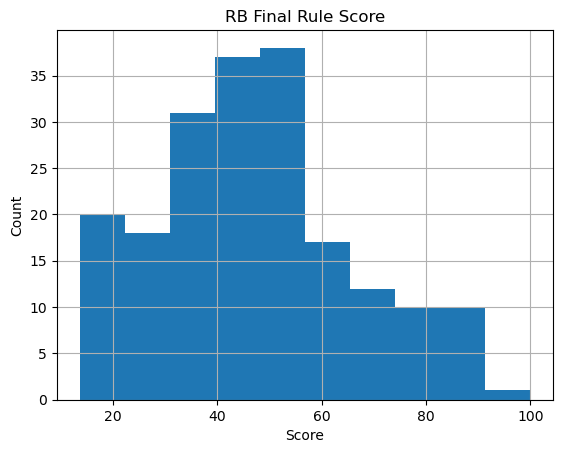

In [62]:
# ▼ adjust path & position ▼
df     = load_and_preprocess(
    'abfs://data@recruitrevealstorage2026.dfs.core.windows.net/RB list 1 - Sheet1.csv',
    position='RB'
)
output = compute_final(df, has_actual=False, position='RB')
print(output.head())

import matplotlib.pyplot as plt
output['final_rule_score'].hist()
plt.title('RB Final Rule Score')
plt.xlabel('Score'); plt.ylabel('Count')
plt.show()

output.to_csv(
    'abfs://data@recruitrevealstorage2026.dfs.core.windows.net/rb_results.csv',
    index=False
)
